In [73]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn import preprocessing
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import scipy
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [129]:
customer_model_data = pd.read_csv('../data/customer_model_data.csv')

In [15]:
customer_model_data.columns

Index(['Data Origin', 'Cust Type', 'KMs Reading', 'Make', 'Model',
       'Order Type', 'Plant Name1', 'Total Amt Wtd Tax.', 'District', 'State',
       'has_policy', 'Segment'],
      dtype='object')

In [16]:
customer_model_data.drop(['Data Origin', 'Plant Name1'], axis=1, inplace=True)

False

In [17]:
customer_model_data['District'].nunique()

3571

In [18]:
cities = customer_model_data['District'].value_counts().reset_index().sort_values(by='District', ascending=False)
cities.columns = ['District', 'city_count']

In [94]:
customer_model_data = customer_model_data.merge(cities, on='District', how='left')

In [95]:
customer_model_data.shape

(492314, 11)

In [96]:
customer_model_data.loc[customer_model_data['city_count'] <= 500, 'District'] = 'Others'

In [98]:
customer_model_data['District'].nunique()

118

In [23]:
customer_model_data['Model'].nunique()

246

In [27]:
model = customer_model_data['Model'].value_counts().reset_index().sort_values(by='Model', ascending=False)
model.columns = ['Model', 'model_count']
model.head()

,Model,model_count
0,SWIFT,31899
1,ALTO,28569
2,SANTRO,24536
3,SCORPIO CRDE,23771
4,WAGONR,22864


In [99]:
model[model['model_count']<=500]['Model'].count()

162

In [100]:
customer_model_data = customer_model_data.merge(model, on='Model', how='left')

In [101]:
customer_model_data.loc[customer_model_data['model_count'] <= 500, 'Model'] = 'Others'

In [104]:
customer_model_data['Model'].nunique()

85

In [32]:
customer_model_data.drop(['city_count', 'model_count'], axis=1, inplace=True)

In [33]:
customer_model_data.columns

Index(['Cust Type', 'KMs Reading', 'Make', 'Model', 'Order Type',
       'Total Amt Wtd Tax.', 'District', 'State', 'has_policy', 'Segment'],
      dtype='object')

In [34]:
customer_model_data.nunique()

Cust Type                  7
KMs Reading           159473
Make                      28
Model                     85
Order Type                 9
Total Amt Wtd Tax.    258071
District                 118
State                     35
has_policy                 2
Segment                    3
dtype: int64

In [35]:
cust_type_enc = pd.get_dummies(customer_model_data['Cust Type'],prefix = 'cust_type_')

make_enc = pd.get_dummies(customer_model_data['Make'],prefix = 'make_')

model_enc =  pd.get_dummies(customer_model_data['Model'],prefix = 'model_')

ot_enc =  pd.get_dummies(customer_model_data['Order Type'],prefix = 'ot_')

state_enc =  pd.get_dummies(customer_model_data['State'],prefix = 'state_')

district_enc =  pd.get_dummies(customer_model_data['District'],prefix = 'district_').astype(np.int8)

data_encoded = pd.concat([cust_type_enc, make_enc, model_enc, ot_enc, state_enc, district_enc],
                         axis=1)

data_encoded = pd.concat([data_encoded, customer_model_data['KMs Reading'], customer_model_data['Total Amt Wtd Tax.'],
                         customer_model_data['has_policy'], customer_model_data['Segment']], axis=1)

In [36]:
data_encoded.shape

(492314, 286)

In [37]:
#normalize numerical features
numerica_df = data_encoded[['KMs Reading', 'Total Amt Wtd Tax.']]

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(numerica_df)
df_normalized = pd.DataFrame(np_scaled, columns = ['KMs Reading', 'Total Amt Wtd Tax.'])
data_encoded[['KMs Reading', 'Total Amt Wtd Tax.']] = df_normalized[['KMs Reading', 'Total Amt Wtd Tax.']]
data_encoded[['KMs Reading', 'Total Amt Wtd Tax.']].head()

,KMs Reading,Total Amt Wtd Tax.
0,0.000300,0.000288
1,0.017298,0.001883
2,0.004241,0.001756
3,0.004241,0.000211
4,0.007904,0.001422


In [38]:
lr_model = LogisticRegression(random_state=0)

In [39]:
X = data_encoded.iloc[:,:-1]
y= data_encoded['Segment']

In [40]:
lr_model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
input_data = ['Retail', 3000, 'HONDA', 'MOBILIO', 'Mechanical', 500, 'hyderabad', 'telangana', 
              '0']
input_df = pd.DataFrame({
    'Cust Type': input_data[0],
    'KMs Reading': input_data[1], 
    'Make': input_data[2], 
    'Model': input_data[3],
    'Order Type': input_data[4], 
    'Total Amt Wtd Tax.': input_data[5], 
    'District': input_data[6], 
    'State': input_data[7],
    'has_policy': input_data[8]
}, index=[0])
categorical_cols = ['Cust Type', 'Make', 'Model', 'Order Type', 'District', 'State']
input_data_encoded = pd.get_dummies(input_df[categorical_cols])
input_data_encoded[['KMs Reading', 'Total Amt Wtd Tax.', 'has_policy']] = input_df[['KMs Reading', 'Total Amt Wtd Tax.', 'has_policy']]
# Get missing columns in the training test
missing_cols = set( data_encoded.columns ) - set( input_data_encoded.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    input_data_encoded[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
input_data_encoded = input_data_encoded[X.columns]

In [42]:
input_data_encoded.shape

(1, 285)

In [43]:
lr_pred = lr_model.predict(input_data_encoded)

In [44]:
lr_pred

array([1], dtype=int64)

In [45]:
def perform_cv(model, X, y):
    f1_scores = []
    for i in range(0,5):
        X_t, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        model.fit(X_t, y_train)
        model_pred = model.predict(X_test)
        print(classification_report(y_test, model_pred))
        f1 = f1_score(y_test, model_pred,average="weighted")
        print("F1 score: "+str(f1))
        f1_scores.append(f1)
    return f1_scores

In [46]:
f1 = perform_cv(lr_model, X, y)

              precision    recall  f1-score   support

           0       0.64      0.72      0.67     65117
           1       0.79      0.72      0.75     95411
           2       0.74      0.57      0.64      1936

    accuracy                           0.72    162464
   macro avg       0.72      0.67      0.69    162464
weighted avg       0.73      0.72      0.72    162464

F1 score: 0.7198566256728364
              precision    recall  f1-score   support

           0       0.64      0.72      0.67     64886
           1       0.79      0.72      0.75     95712
           2       0.76      0.58      0.66      1866

    accuracy                           0.72    162464
   macro avg       0.73      0.67      0.70    162464
weighted avg       0.73      0.72      0.72    162464

F1 score: 0.7211446904046404
              precision    recall  f1-score   support

           0       0.64      0.72      0.68     65552
           1       0.78      0.72      0.75     95087
           2     

In [47]:
np.mean(f1)

0.7204444193216296

#### We are getting average accuracy of 72% and f1 score of 0.72 with logistic

In [65]:
#for feature engineering, removing one feature at a time and checking model performance
col_list = ['Cust Type', 'KMs Reading', 'Make', 'Model', 'Order Type', 'Total Amt Wtd Tax.', 'District', 'State', 'has_policy']
f1_scores = []
for col in col_list:
    
    #removing one feature at a time
    data = pd.read_csv('../data/customer_model_data.csv')
    data.drop(col, axis=1, inplace=True)
    print("Removed column: "+col)
    
    #irrelevant features
    data.drop(['Data Origin', 'Plant Name1'], axis=1, inplace=True)

    if 'District' in data.columns:
        cities = data['District'].value_counts().reset_index().sort_values(by='District', ascending=False)
        cities.columns = ['District', 'city_count']
        data = data.merge(cities, on='District', how='left')
        data.loc[data['city_count'] <= 500, 'District'] = 'Others'

    if 'Model' in data.columns:
        model = data['Model'].value_counts().reset_index().sort_values(by='Model', ascending=False)
        model.columns = ['Model', 'model_count']
        data = data.merge(model, on='Model', how='left')
        data.loc[data['model_count'] <= 500, 'Model'] = 'Others'
    
    if 'city_count' in data.columns:
        data.drop('city_count', axis=1, inplace=True)
    
    if 'model_count' in data.columns:
        data.drop('model_count', axis=1, inplace=True)
    
    data_encoded = pd.DataFrame()
    for numeric_col in ['KMs Reading', 'Total Amt Wtd Tax.', 'has_policy']:
        if numeric_col in data.columns:
            data_encoded = pd.concat([data_encoded, data[numeric_col]], axis=1)


    current_cols = data.columns
    for curr_col in current_cols:
        if data[curr_col].dtype == 'object':
            col_enc = pd.get_dummies(data[curr_col])
            data_encoded = pd.concat([data_encoded, col_enc], axis=1)

            
    X = data_encoded.iloc[:,:-1]
    y= data['Segment']
    
    X_t, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    print("Fitting the model...")
    lr_model.fit(X_t, y_train)
    print("Predicting...")
    model_pred = lr_model.predict(X_test)
    print(classification_report(y_test, model_pred))
    f1 = f1_score(y_test, model_pred,average="weighted")
    print("F1 score: "+str(f1))
    f1_scores.append(f1)

Removed column: Cust Type
Fitting the model...
Predicting...
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     65199
           1       0.59      1.00      0.74     95372
           2       0.00      0.00      0.00      1893

    accuracy                           0.59    162464
   macro avg       0.20      0.33      0.25    162464
weighted avg       0.34      0.59      0.43    162464

F1 score: 0.434281249935926
Removed column: KMs Reading
Fitting the model...
Predicting...
              precision    recall  f1-score   support

           0       0.62      0.39      0.48     64888
           1       0.67      0.85      0.75     95735
           2       0.00      0.00      0.00      1841

    accuracy                           0.66    162464
   macro avg       0.43      0.41      0.41    162464
weighted avg       0.64      0.66      0.63    162464

F1 score: 0.6339519519208323
Removed column: Make
Fitting the model...
Predicting...
 

In [86]:
matplotlib.rcParams.update({'font.size': 12})

Text(0, 0.5, 'f1 score')

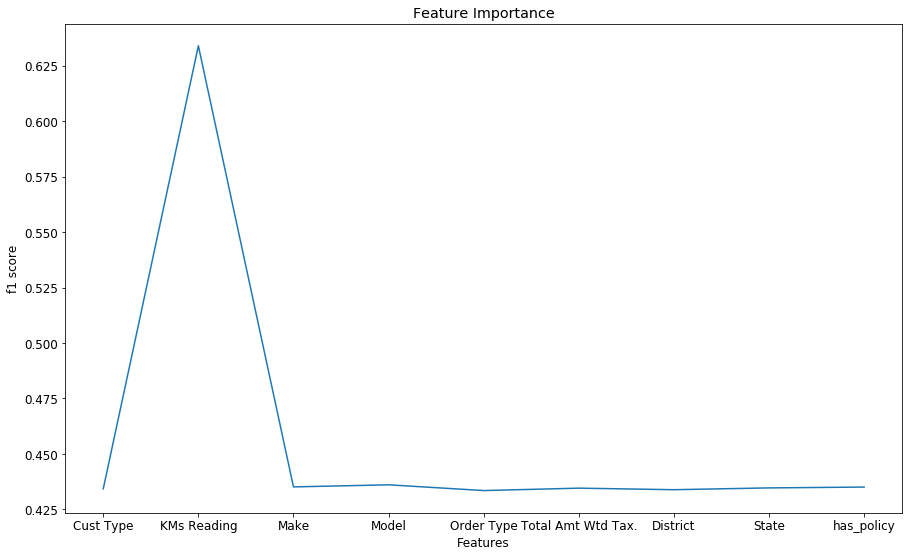

In [87]:
plt.figure(figsize=(15,9))
plt.plot(col_list, f1_scores)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('f1 score')

In [190]:
#upsampling low and high segments

ros = RandomOverSampler(random_state=3)
data_res, label_res = ros.fit_sample(X, y)

In [193]:
label_res.value_counts()

2    289210
1    289210
0    289210
Name: Segment, dtype: int64

In [194]:
f1 = perform_cv(lr_model, data_res, label_res)

              precision    recall  f1-score   support

           0       0.66      0.81      0.73     95218
           1       0.81      0.60      0.69     95557
           2       0.91      0.95      0.93     95543

    accuracy                           0.79    286318
   macro avg       0.80      0.79      0.78    286318
weighted avg       0.80      0.79      0.78    286318

F1 score: 0.7824816237596645
              precision    recall  f1-score   support

           0       0.66      0.81      0.73     95414
           1       0.81      0.59      0.69     95340
           2       0.91      0.95      0.93     95564

    accuracy                           0.79    286318
   macro avg       0.79      0.78      0.78    286318
weighted avg       0.79      0.79      0.78    286318

F1 score: 0.7817903894635123
              precision    recall  f1-score   support

           0       0.67      0.81      0.73     95646
           1       0.81      0.60      0.69     95066
           2     

In [195]:
np.mean(f1)

0.7822511748513435

#### After upsampling, we are getting 0.78 f1 score and 79% accuracy

In [198]:
dtree = DecisionTreeClassifier(random_state=0)

In [199]:
f1 = perform_cv(dtree, data_res, label_res)

              precision    recall  f1-score   support

           0       0.76      0.80      0.78     95453
           1       0.79      0.74      0.76     95377
           2       1.00      1.00      1.00     95488

    accuracy                           0.85    286318
   macro avg       0.85      0.85      0.85    286318
weighted avg       0.85      0.85      0.85    286318

F1 score: 0.8472006674025124
              precision    recall  f1-score   support

           0       0.76      0.81      0.78     95334
           1       0.79      0.74      0.76     95501
           2       1.00      1.00      1.00     95483

    accuracy                           0.85    286318
   macro avg       0.85      0.85      0.85    286318
weighted avg       0.85      0.85      0.85    286318

F1 score: 0.8479332682387895
              precision    recall  f1-score   support

           0       0.76      0.81      0.78     95510
           1       0.79      0.74      0.76     95314
           2     

In [201]:
np.mean(f1)

0.8474741866609058

#### Decision Tree: 85% accuracy and f1 score = 0.85

In [203]:
rf = RandomForestClassifier(random_state=0)

f1 = perform_cv(rf, data_res, label_res)

              precision    recall  f1-score   support

           0       0.77      0.85      0.81     95246
           1       0.83      0.74      0.79     95657
           2       1.00      1.00      1.00     95415

    accuracy                           0.86    286318
   macro avg       0.87      0.86      0.86    286318
weighted avg       0.87      0.86      0.86    286318

F1 score: 0.863524322666442
              precision    recall  f1-score   support

           0       0.77      0.84      0.80     95344
           1       0.83      0.74      0.78     95541
           2       1.00      1.00      1.00     95433

    accuracy                           0.86    286318
   macro avg       0.86      0.86      0.86    286318
weighted avg       0.86      0.86      0.86    286318

F1 score: 0.8622276121691583
              precision    recall  f1-score   support

           0       0.77      0.85      0.81     95379
           1       0.83      0.74      0.78     95549
           2      

In [212]:
with open('../pickles/logistic_segment.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

In [209]:
with open('../pickles/dtree_segment.pkl', 'wb') as f:
    pickle.dump(dtree, f)

In [210]:
with open('../pickles/rf_segment.pkl', 'wb') as f:
    pickle.dump(rf, f)

In [217]:
with open('../pickles/rf_segment.pkl', 'rb') as f:
    model = pickle.load(f)

In [218]:
model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [130]:
make = customer_model_data['Make'].value_counts().reset_index().sort_values(by='Make', ascending=False)
make.columns = ['Make', 'make_count']
make

,Make,make_count
0,MARUTI SUZUKI,147102
1,MAHINDRA & MAHINDRA,87356
2,HYUNDAI,85342
3,TATA MOTORS,58034
4,GENERAL MOTORS,29092
5,FORD,21616
6,TOYOTA,19466
7,HONDA,15464
8,SKODA,6515
9,FIAT,6437


In [131]:
customer_model_data = customer_model_data.merge(make, on='Make', how='left')

In [132]:
customer_model_data.loc[customer_model_data['make_count'] <= 10000, 'Make'] = 'Others'

In [133]:
customer_model_data.columns

Index(['Data Origin', 'Cust Type', 'KMs Reading', 'Make', 'Model',
       'Order Type', 'Plant Name1', 'Total Amt Wtd Tax.', 'District', 'State',
       'has_policy', 'Segment', 'make_count'],
      dtype='object')

In [135]:
total_revenue_by_brand = customer_model_data.groupby('Make')['Total Amt Wtd Tax.'].sum().reset_index().sort_values(by='Total Amt Wtd Tax.', ascending=False)

In [136]:
plt.rcParams.update({'font.size': 15})

Text(0.5, 0, 'Total Value')

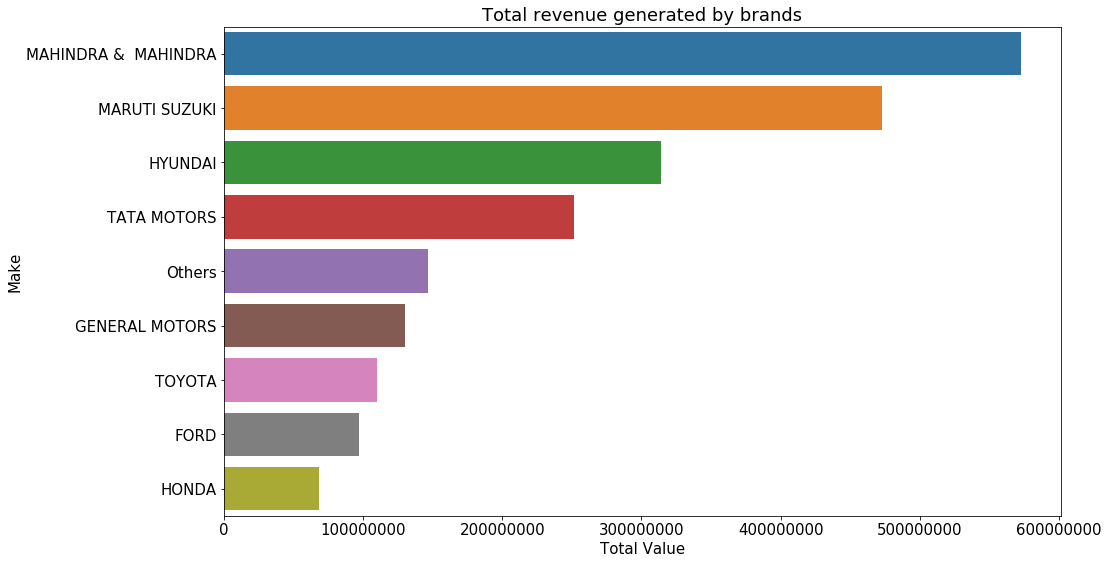

In [139]:
plt.figure(figsize=(15,9))
plt.ticklabel_format(style='plain', axis='x')
plt.title('Total revenue generated by brands')
ax = sns.barplot(x='Total Amt Wtd Tax.', y='Make', data=total_revenue_by_brand)
ax.set_xlabel('Total Value')

In [140]:
invoice_data = pd.read_csv('../data/invoice_data.csv')
invoice_data.head()

,Area / Locality,CITY,Cash /Cashless Type,Claim No.,Cust Type,Customer No.,District,Expiry Date,Gate Pass Date,Gate Pass Time,...,Regn No,Service Advisor Name,Technician Name,Total Amt Wtd Tax.,Total Value,User ID,Invoice Day,Invoice Month,Invoice Year,Day of the week
0,MAJIWADA,Thane,NaN,NaN,Retail,67849,Maharashtra,NaN,NaN,00:00:00,...,KA19MA1291,NaN,RUPESH,4051.95,4051.95,BC01FS1,2,1,2015,Friday
1,THNAE,THNAE,NaN,NaN,Retail,84419,Maharashtra,NaN,NaN,00:00:00,...,MH43R3046,NaN,PRASHANT,1001.29,1001.29,BC01SA2,3,1,2015,Saturday
2,THANE,THANE[W],NaN,NaN,Retail,81055,Maharashtra,NaN,NaN,00:00:00,...,AP09AX0582,NaN,IMRAN,233.14,233.14,BC01SA2,3,1,2015,Saturday
3,THNAE,THNAE,NaN,NaN,Retail,84419,Maharashtra,NaN,NaN,00:00:00,...,MH43R3046,NaN,PRASHANT,0.00,0.00,BC01SA2,3,1,2015,Saturday
4,THANE,THANE,NaN,NaN,Retail,18980,Maharashtra,NaN,NaN,00:00:00,...,MH04CD9768,NaN,DAYANAND,2747.12,2747.12,BC01SA2,3,1,2015,Saturday


In [151]:
make = invoice_data['Make'].value_counts().reset_index().sort_values(by='Make', ascending=False)
make.columns = ['Make', 'make_count']


invoice_data = invoice_data.merge(make, on='Make', how='left')

invoice_data.loc[invoice_data['make_count'] <= 10000, 'Make'] = 'Others'

total_labour_by_brand = invoice_data.groupby('Make')['Labour Total'].sum().reset_index().sort_values(by='Labour Total', ascending=False)

Text(0.5, 0, 'Labour cost')

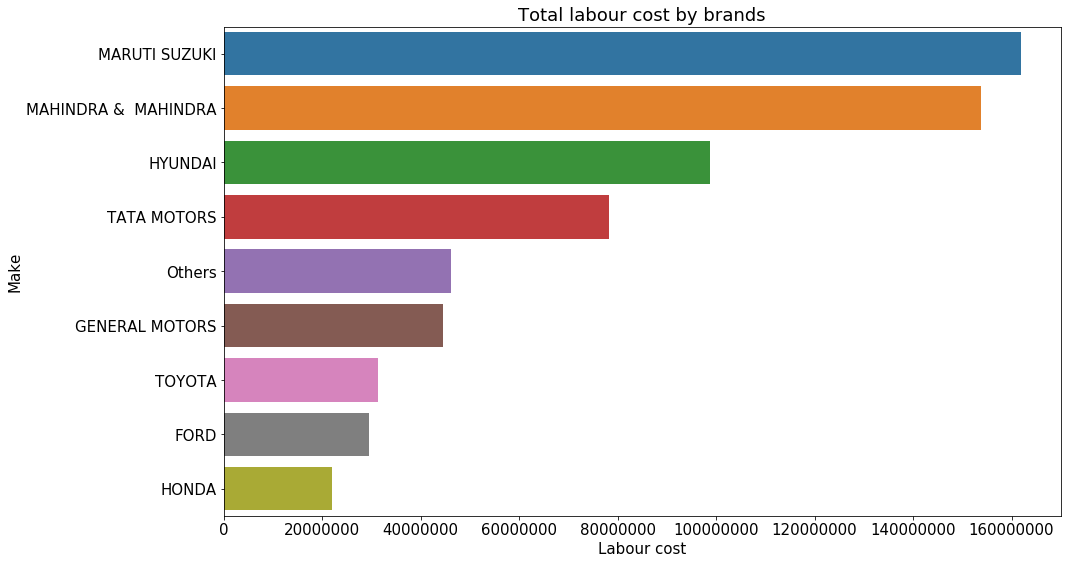

In [153]:
plt.figure(figsize=(15,9))
plt.ticklabel_format(style='plain', axis='x')
plt.title('Total labour cost by brands')
ax = sns.barplot(x='Labour Total', y='Make', data=total_labour_by_brand)
ax.set_xlabel('Labour cost')

Text(0.5, 0, 'percent')

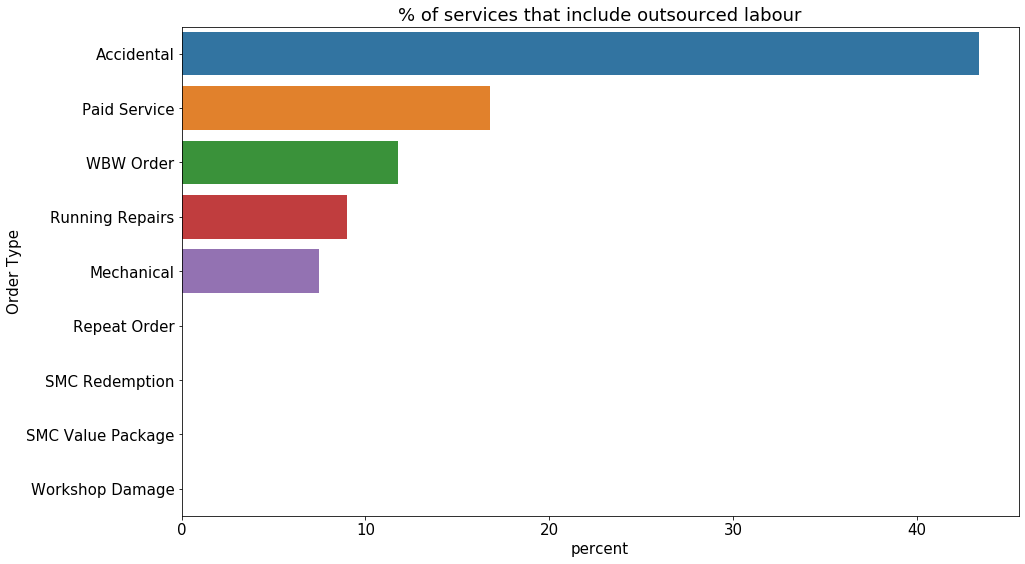

In [156]:
osl_by_brand = invoice_data[['OSL Total','Order Type']]
osl_by_brand_nonzero_count = osl_by_brand.groupby('Order Type').agg(lambda x: x.ne(0.0).sum()).reset_index()

osl_count = osl_by_brand.groupby('Order Type').agg(['mean', 'count'])
osl_by_brand_nonzero_count['count'] = osl_count['OSL Total']['count'].reset_index()['count']
osl_by_brand_nonzero_count['percent'] = (osl_by_brand_nonzero_count['OSL Total']/osl_by_brand_nonzero_count['count'])*100

osl_by_brand_nonzero_count.sort_values(by='percent', ascending=False, inplace=True)

plt.figure(figsize=(15,9))
plt.ticklabel_format(style='plain', axis='x')
plt.title('% of services that include outsourced labour')
ax = sns.barplot(x='percent', y='Order Type', data=osl_by_brand_nonzero_count)
ax.set_xlabel('percent')

In [162]:
invoice_data['Insurance Company'].notnull().sum()

23591

In [159]:
invoice_data.shape

(492314, 51)